
# Контрольная работа №1: Обработка гармонических и полигармонических сигналов

Этот ноутбук содержит выполнение заданий:
- Пункт 2: Обработка гармонических сигналов (DFT, спектры, восстановление)
- Пункт 3: Обработка полигармонических сигналов (формирование, восстановление)
- Пункт 4: Реализация быстрого преобразования Фурье (БПФ)
- Пункт 5: Цифровая фильтрация сигналов (НЧ, ВЧ, полосовой фильтр)


In [29]:

import numpy as np
import matplotlib.pyplot as plt
from math import pi
import time
np.random.seed(1)


In [30]:

# Пункт 2а: Разработка функции для вычисления дискретного преобразования Фурье

def make_sin_cos_tables(N):
    """Создание таблиц sin/cos для оптимизации вычислений DFT"""
    k = np.arange(N)
    ang = 2*np.pi*k/N
    return np.cos(ang), np.sin(ang)

def dft_harmonic(x, N, j, cos_table, sin_table):
    """Вычисление DFT для отдельной гармоники j"""
    Ac = 0.0
    As = 0.0
    for i in range(N):
        idx = (j * i) % N
        Ac += x[i] * cos_table[idx]
        As += x[i] * sin_table[idx]
    Ac *= 2.0 / N
    As *= 2.0 / N
    A = np.sqrt(Ac*Ac + As*As)
    phi = np.arctan2(As, Ac)
    return Ac, As, A, phi

def spectrum_all(x, N, cos_table, sin_table):
    """Вычисление полного спектра сигнала (амплитудный и фазовый)"""
    max_j = N//2
    Acs = np.zeros(max_j)
    Ass = np.zeros(max_j)
    A = np.zeros(max_j)
    phi = np.zeros(max_j)
    for j in range(max_j):
        Acs[j], Ass[j], A[j], phi[j] = dft_harmonic(x, N, j, cos_table, sin_table)
    return Acs, Ass, A, phi

def reconstruct_from_A_phi(A, phi, N):
    """Восстановление сигнала по амплитудному и фазовому спектрам"""
    max_j = len(A)
    y = np.zeros(N)
    if max_j > 0:
        y += A[0]/2.0
    for j in range(1, max_j):
        for i in range(N):
            y[i] += A[j]*np.cos(2*np.pi*j*i/N - phi[j])
    return y


In [31]:
# Пункт 4: Разработка программной функции для реализации быстрого преобразования Фурье

def my_fft(x):
    """
    Собственная реализация быстрого преобразования Фурье (БПФ)
    Использует алгоритм Cooley-Tukey для N = 2^k
    """
    N = len(x)
    
    # Проверяем, что N является степенью двойки
    if N & (N - 1) != 0:
        raise ValueError("N должно быть степенью двойки для FFT")
    
    # Базовый случай
    if N == 1:
        return x
    
    # Рекурсивно вычисляем FFT для четных и нечетных индексов
    even = my_fft(x[::2])
    odd = my_fft(x[1::2])
    
    # Объединяем результаты
    result = np.zeros(N, dtype=complex)
    for k in range(N // 2):
        t = np.exp(-2j * np.pi * k / N) * odd[k]
        result[k] = even[k] + t
        result[k + N // 2] = even[k] - t
    
    return result

def my_ifft(X):
    """Обратное быстрое преобразование Фурье (ОБПФ)"""
    N = len(X)
    # IFFT через FFT с комплексным сопряжением
    x_conj = my_fft(np.conj(X))
    return np.conj(x_conj) / N


In [32]:
# Пункт 5: Реализация цифровой фильтрации сигналов

def low_pass_filter(x, cutoff_freq, N):
    """НЧ-фильтр через удаление высокочастотных компонент в частотной области"""
    X = my_fft(x)
    mask = np.zeros(N, dtype=bool)
    cutoff_bin = int(cutoff_freq * N)
    mask[:cutoff_bin] = True
    mask[N-cutoff_bin:] = True  # Для симметрии
    X_filtered = X * mask
    x_filtered = np.real(my_ifft(X_filtered))
    return x_filtered

def high_pass_filter(x, cutoff_freq, N):
    """ВЧ-фильтр через удаление низкочастотных компонент в частотной области"""
    X = my_fft(x)
    mask = np.ones(N, dtype=bool)
    cutoff_bin = int(cutoff_freq * N)
    mask[:cutoff_bin] = False
    mask[N-cutoff_bin:] = False  # Для симметрии
    X_filtered = X * mask
    x_filtered = np.real(my_ifft(X_filtered))
    return x_filtered

def band_pass_filter(x, low_cutoff, high_cutoff, N):
    """Полосовой фильтр - пропускает частоты в заданном диапазоне"""
    X = my_fft(x)
    mask = np.zeros(N, dtype=bool)
    low_bin = int(low_cutoff * N)
    high_bin = int(high_cutoff * N)
    mask[low_bin:high_bin] = True
    mask[N-high_bin:N-low_bin] = True  # Для симметрии
    X_filtered = X * mask
    x_filtered = np.real(my_ifft(X_filtered))
    return x_filtered


In [33]:
# Пункт 2а и 3а: Формирование тестовых сигналов

def single_tone(N):
    """Формирование одногармонического тестового сигнала"""
    i = np.arange(N)
    return 10.0 * np.cos(2*np.pi * i / N)

def polyharmonic(N, J=30, amplitude_choices=None, phase_choices=None):
    """Формирование полигармонического сигнала (пункт 3а)"""
    if amplitude_choices is None:
        amplitude_choices = [1,3,5,8,10,12,16]
    if phase_choices is None:
        phase_choices = [pi/6, pi/4, pi/3, pi/2, 3*pi/4, pi]
    i = np.arange(N)
    x = np.zeros(N)
    B = np.random.choice(amplitude_choices, size=J)
    ph = np.random.choice(phase_choices, size=J)
    for j in range(1, J+1):
        x += B[j-1] * np.cos(2*np.pi*j*i/N - ph[j-1])
    return x, B, ph


In [34]:
# Пункт 2: Обработка гармонических сигналов
# Пункт 3: Обработка полигармонических сигналов

def demonstrate_analysis(N=128, J=30):
    """
    Выполнение пунктов 2 и 3:
    - Пункт 2а: DFT, формирование тестовых сигналов, построение спектров
    - Пункт 2б: Восстановление сигнала по спектру и сравнение
    - Пункт 3а: Формирование полигармонического сигнала
    - Пункт 3б: Восстановление исходного сигнала по спектру
    - Пункт 3в: Восстановление без учета начальных фаз
    """
    cos_table, sin_table = make_sin_cos_tables(N)
    
    # Пункт 2а: Одногармонический сигнал
    print("=== Пункт 2: Обработка гармонических сигналов ===")
    x1 = single_tone(N)
    Acs1, Ass1, A1, phi1 = spectrum_all(x1, N, cos_table, sin_table)
    
    # Пункт 2б: Восстановление
    y1 = reconstruct_from_A_phi(A1, phi1, N)
    mse1 = np.mean((x1 - y1)**2)
    max_err1 = np.max(np.abs(x1 - y1))
    print(f"Одногармонический сигнал: MSE = {mse1:.3e}, max error = {max_err1:.3e}")
    
    # Пункт 3а: Полигармонический сигнал
    print("\n=== Пункт 3: Обработка полигармонических сигналов ===")
    x2, B, ph = polyharmonic(N, J=J)
    Acs2, Ass2, A2, phi2 = spectrum_all(x2, N, cos_table, sin_table)
    
    # Пункт 3б: Восстановление с фазами
    y2 = reconstruct_from_A_phi(A2, phi2, N)
    mse2 = np.mean((x2 - y2)**2)
    max_err2 = np.max(np.abs(x2 - y2))
    print(f"Полигармонический сигнал (с фазами): MSE = {mse2:.3e}, max error = {max_err2:.3e}")
    
    # Пункт 3в: Восстановление без фаз
    y2_no_phase = reconstruct_from_A_phi(A2, np.zeros_like(phi2), N)
    mse2_no_phase = np.mean((x2 - y2_no_phase)**2)
    max_err2_no_phase = np.max(np.abs(x2 - y2_no_phase))
    print(f"Полигармонический сигнал (без фаз): MSE = {mse2_no_phase:.3e}, max error = {max_err2_no_phase:.3e}")
    
    # Построение графиков
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    i = np.arange(N)
    
    # Одногармонический: восстановление
    axes[0, 0].plot(i, x1, 'b-', label='x(i) исходный', linewidth=2)
    axes[0, 0].plot(i, y1, 'r--', label='y(i) восстановленный', linewidth=2)
    axes[0, 0].set_title('Пункт 2б: Одногармонический сигнал')
    axes[0, 0].set_xlabel('i'); axes[0, 0].set_ylabel('Амплитуда')
    axes[0, 0].legend(); axes[0, 0].grid(True)
    
    # Одногармонический: амплитудный спектр
    js = np.arange(len(A1))
    axes[0, 1].stem(js, A1, basefmt=" ")
    axes[0, 1].set_title('Пункт 2а: Амплитудный спектр')
    axes[0, 1].set_xlabel('j'); axes[0, 1].set_ylabel('A_j')
    axes[0, 1].grid(True)
    
    # Одногармонический: фазовый спектр
    axes[1, 0].stem(js, phi1, basefmt=" ")
    axes[1, 0].set_title('Пункт 2а: Фазовый спектр')
    axes[1, 0].set_xlabel('j'); axes[1, 0].set_ylabel('φ_j')
    axes[1, 0].grid(True)
    
    # Полигармонический: восстановление
    axes[1, 1].plot(i, x2, 'b-', label='x(i) исходный', linewidth=2)
    axes[1, 1].plot(i, y2, 'r--', label='y(i) с фазами', linewidth=2)
    axes[1, 1].plot(i, y2_no_phase, 'g:', label='y(i) без фаз', linewidth=2)
    axes[1, 1].set_title(f'Пункт 3б, 3в: Полигармонический сигнал (J={J})')
    axes[1, 1].set_xlabel('i'); axes[1, 1].set_ylabel('Амплитуда')
    axes[1, 1].legend(); axes[1, 1].grid(True)
    
    # Полигармонический: амплитудный спектр
    js2 = np.arange(len(A2))
    axes[2, 0].stem(js2, A2, basefmt=" ")
    axes[2, 0].set_title('Пункт 3а: Амплитудный спектр')
    axes[2, 0].set_xlabel('j'); axes[2, 0].set_ylabel('A_j')
    axes[2, 0].grid(True)
    
    # Полигармонический: фазовый спектр
    axes[2, 1].stem(js2, phi2, basefmt=" ")
    axes[2, 1].set_title('Пункт 3а: Фазовый спектр')
    axes[2, 1].set_xlabel('j'); axes[2, 1].set_ylabel('φ_j')
    axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'single': {'x': x1, 'y': y1, 'A': A1, 'phi': phi1, 'mse': mse1, 'max_err': max_err1},
        'poly': {'x': x2, 'y': y2, 'y_no_phase': y2_no_phase, 'A': A2, 'phi': phi2, 
                 'mse': mse2, 'max_err': max_err2, 'mse_no_phase': mse2_no_phase, 'max_err_no_phase': max_err2_no_phase}
    }


=== Пункт 2: Обработка гармонических сигналов ===
Одногармонический сигнал: MSE = 3.125e-30, max error = 7.105e-15

=== Пункт 3: Обработка полигармонических сигналов ===
Полигармонический сигнал (с фазами): MSE = 2.913e-26, max error = 6.786e-13
Полигармонический сигнал (без фаз): MSE = 1.903e+03, max error = 2.249e+02


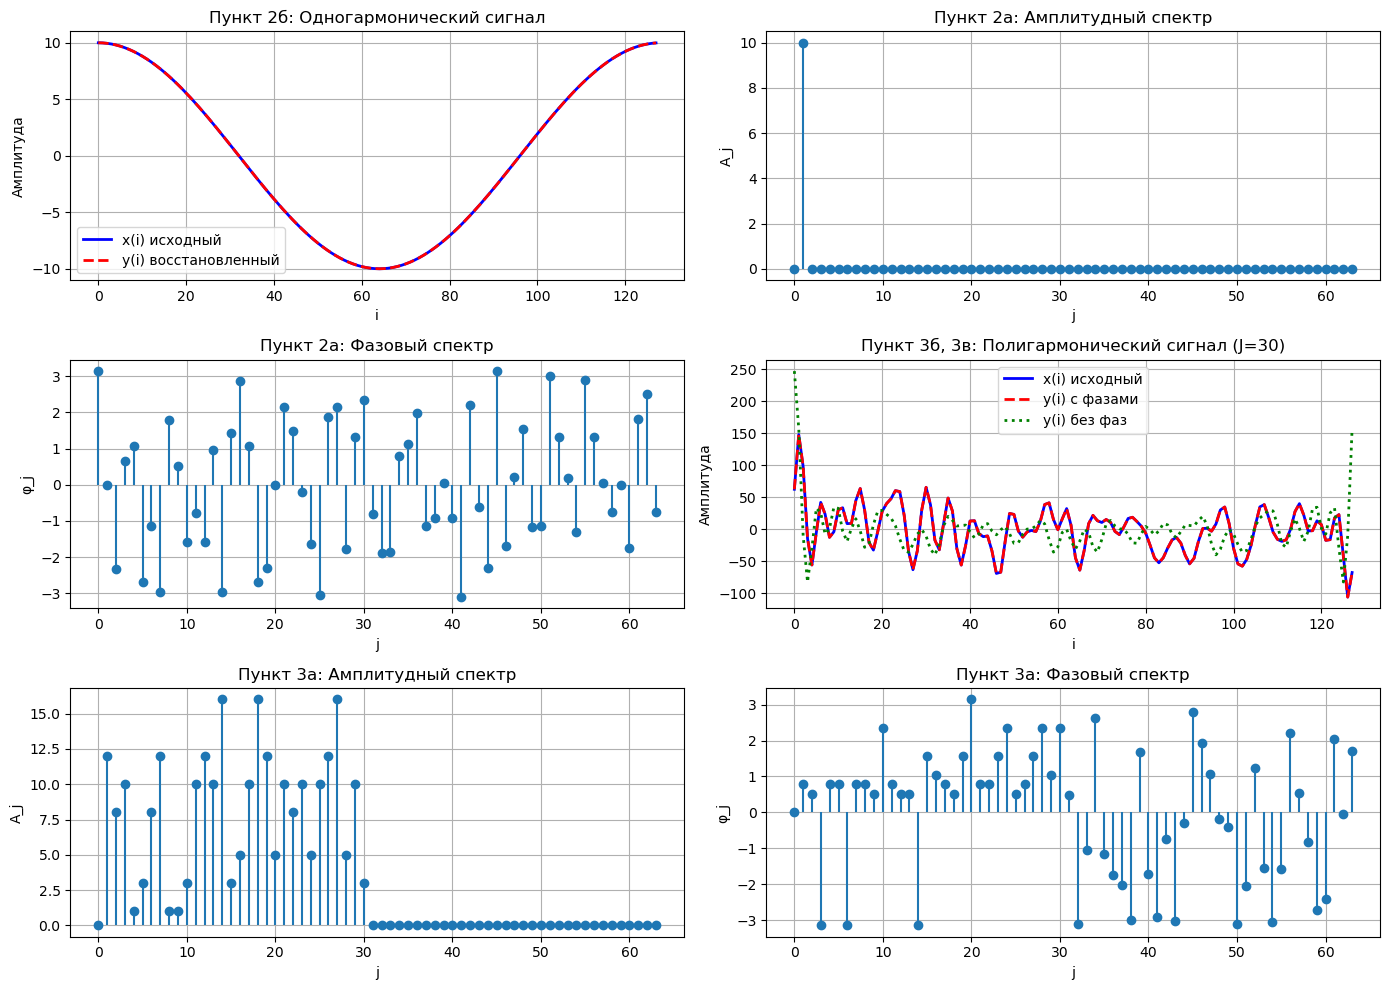

In [35]:
# Выполнение пунктов 2 и 3
results_dft = demonstrate_analysis(N=128, J=30)


=== Пункт 4: Проверка БПФ на полигармонических сигналах ===
Максимальная ошибка между БПФ и ДПФ: 8.88e-15


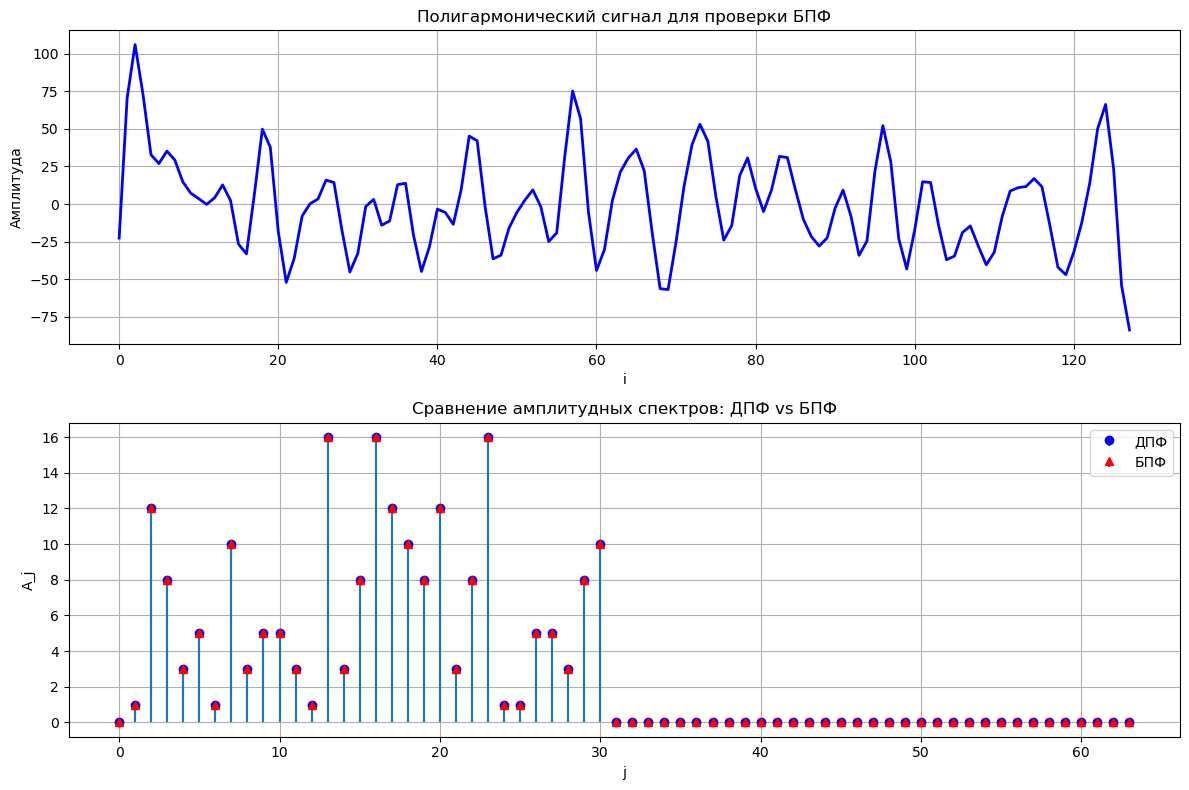

In [36]:

# Пункт 4: Проверка работоспособности БПФ при обработке полигармонических сигналов

def test_fft_on_polyharmonic(N=128, J=30):
    """Проверка БПФ на полигармонических сигналах"""
    print("=== Пункт 4: Проверка БПФ на полигармонических сигналах ===")
    
    # Создаем полигармонический сигнал
    x, _, _ = polyharmonic(N, J=J)
    
    # Вычисляем БПФ
    X_fft = my_fft(x)
    
    # Вычисляем амплитудный спектр
    A_fft = (2.0/N) * np.abs(X_fft[:N//2])
    
    # Сравниваем с DFT
    cos_table, sin_table = make_sin_cos_tables(N)
    _, _, A_dft, _ = spectrum_all(x, N, cos_table, sin_table)
    
    # Ошибка сравнения
    error = np.max(np.abs(A_fft - A_dft))
    print(f"Максимальная ошибка между БПФ и ДПФ: {error:.2e}")
    
    # Визуализация
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    i = np.arange(N)
    js = np.arange(len(A_fft))
    
    # Сигнал во временной области
    axes[0].plot(i, x, 'b-', linewidth=2)
    axes[0].set_title('Полигармонический сигнал для проверки БПФ')
    axes[0].set_xlabel('i'); axes[0].set_ylabel('Амплитуда')
    axes[0].grid(True)
    
    # Сравнение спектров
    axes[1].stem(js, A_dft, basefmt=" ", label='ДПФ', markerfmt='bo')
    axes[1].stem(js, A_fft, basefmt=" ", label='БПФ', markerfmt='r^')
    axes[1].set_title('Сравнение амплитудных спектров: ДПФ vs БПФ')
    axes[1].set_xlabel('j'); axes[1].set_ylabel('A_j')
    axes[1].legend(); axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return X_fft, A_fft, A_dft

# Выполнение пункта 4
results_fft = test_fft_on_polyharmonic(N=128, J=30)


=== Пункт 5: Цифровая фильтрация сигналов ===


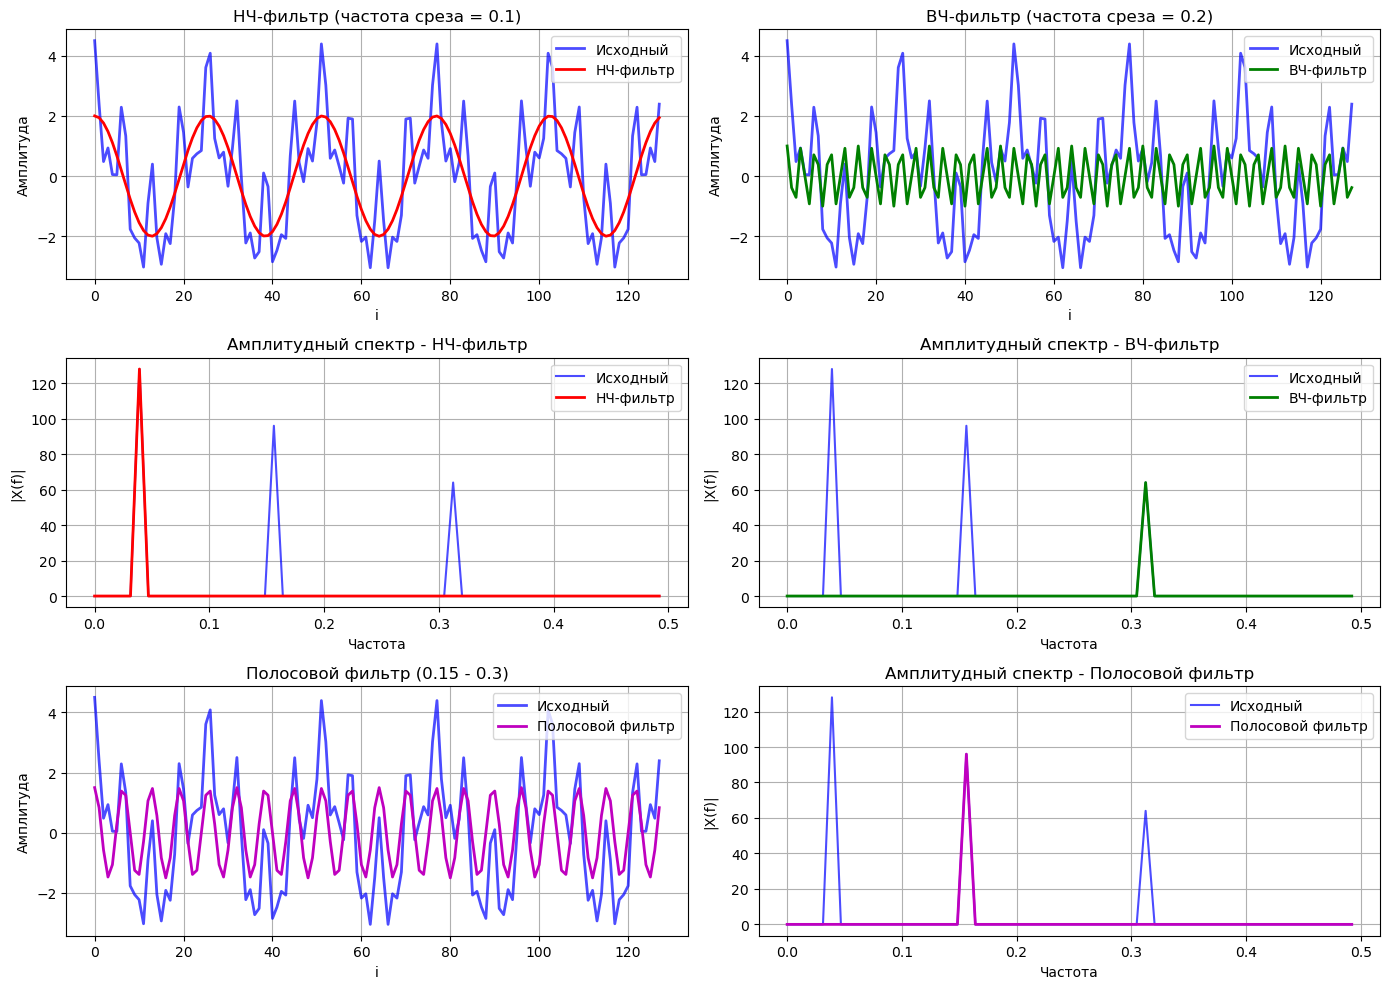


Фильтрация выполнена успешно


In [37]:

# Пункт 5: Реализация цифровой фильтрации сигналов

def demonstrate_filters(N=128):
    """
    Демонстрация цифровой фильтрации:
    - НЧ-фильтр
    - ВЧ-фильтр
    - Полосовой фильтр
    """
    print("=== Пункт 5: Цифровая фильтрация сигналов ===")
    
    # Создаем тестовый сигнал с разными частотными компонентами
    i = np.arange(N)
    x = (2.0 * np.cos(2 * np.pi * 5 * i / N) +      # Низкая частота
         1.5 * np.cos(2 * np.pi * 20 * i / N) +     # Средняя частота
         1.0 * np.cos(2 * np.pi * 40 * i / N))      # Высокая частота
    
    # Применяем фильтры
    x_lp = low_pass_filter(x, 0.1, N)      # НЧ-фильтр
    x_hp = high_pass_filter(x, 0.2, N)     # ВЧ-фильтр
    x_bp = band_pass_filter(x, 0.15, 0.3, N)  # Полосовой фильтр
    
    # Вычисляем спектры для визуализации
    X_original = my_fft(x)
    X_lp = my_fft(x_lp)
    X_hp = my_fft(x_hp)
    X_bp = my_fft(x_bp)
    freqs = np.arange(N) / N
    
    # Графики
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    
    # Временная область
    axes[0, 0].plot(i, x, 'b-', label='Исходный', linewidth=2, alpha=0.7)
    axes[0, 0].plot(i, x_lp, 'r-', label='НЧ-фильтр', linewidth=2)
    axes[0, 0].set_title('НЧ-фильтр (частота среза = 0.1)')
    axes[0, 0].set_xlabel('i'); axes[0, 0].set_ylabel('Амплитуда')
    axes[0, 0].legend(); axes[0, 0].grid(True)
    
    axes[0, 1].plot(i, x, 'b-', label='Исходный', linewidth=2, alpha=0.7)
    axes[0, 1].plot(i, x_hp, 'g-', label='ВЧ-фильтр', linewidth=2)
    axes[0, 1].set_title('ВЧ-фильтр (частота среза = 0.2)')
    axes[0, 1].set_xlabel('i'); axes[0, 1].set_ylabel('Амплитуда')
    axes[0, 1].legend(); axes[0, 1].grid(True)
    
    # Частотная область - амплитудный спектр
    axes[1, 0].plot(freqs[:N//2], np.abs(X_original[:N//2]), 'b-', label='Исходный', alpha=0.7)
    axes[1, 0].plot(freqs[:N//2], np.abs(X_lp[:N//2]), 'r-', label='НЧ-фильтр', linewidth=2)
    axes[1, 0].set_title('Амплитудный спектр - НЧ-фильтр')
    axes[1, 0].set_xlabel('Частота'); axes[1, 0].set_ylabel('|X(f)|')
    axes[1, 0].legend(); axes[1, 0].grid(True)
    
    axes[1, 1].plot(freqs[:N//2], np.abs(X_original[:N//2]), 'b-', label='Исходный', alpha=0.7)
    axes[1, 1].plot(freqs[:N//2], np.abs(X_hp[:N//2]), 'g-', label='ВЧ-фильтр', linewidth=2)
    axes[1, 1].set_title('Амплитудный спектр - ВЧ-фильтр')
    axes[1, 1].set_xlabel('Частота'); axes[1, 1].set_ylabel('|X(f)|')
    axes[1, 1].legend(); axes[1, 1].grid(True)
    
    # Полосовой фильтр
    axes[2, 0].plot(i, x, 'b-', label='Исходный', linewidth=2, alpha=0.7)
    axes[2, 0].plot(i, x_bp, 'm-', label='Полосовой фильтр', linewidth=2)
    axes[2, 0].set_title('Полосовой фильтр (0.15 - 0.3)')
    axes[2, 0].set_xlabel('i'); axes[2, 0].set_ylabel('Амплитуда')
    axes[2, 0].legend(); axes[2, 0].grid(True)
    
    axes[2, 1].plot(freqs[:N//2], np.abs(X_original[:N//2]), 'b-', label='Исходный', alpha=0.7)
    axes[2, 1].plot(freqs[:N//2], np.abs(X_bp[:N//2]), 'm-', label='Полосовой фильтр', linewidth=2)
    axes[2, 1].set_title('Амплитудный спектр - Полосовой фильтр')
    axes[2, 1].set_xlabel('Частота'); axes[2, 1].set_ylabel('|X(f)|')
    axes[2, 1].legend(); axes[2, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nФильтрация выполнена успешно")
    
    return {
        'original': x,
        'low_pass': x_lp,
        'high_pass': x_hp,
        'band_pass': x_bp
    }

# Выполнение пункта 5
results_filters = demonstrate_filters(N=128)
